<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Lightning_for_is_she's_gorgeous_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 925 kB 5.0 MB/s 
     |████████████████████████████████| 636 kB 56.5 MB/s 
     |████████████████████████████████| 125 kB 72.7 MB/s 
     |████████████████████████████████| 282 kB 63.4 MB/s 
     |████████████████████████████████| 829 kB 71.8 MB/s 
     |████████████████████████████████| 1.3 MB 41.6 MB/s 
     |████████████████████████████████| 271 kB 46.2 MB/s 
     |████████████████████████████████| 160 kB 45.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=02628d3ad44c0c236a543a535310841b199573154fff1d4910368f032cce592b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/beauty-detection-data-set

100% 140M/140M [00:01<00:00, 102MB/s] 



In [ ]:
from zipfile import ZipFile
file_name = "/content/beauty-detection-data-set.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

%matplotlib inline



In [ ]:
BATCH_SIZE = 128
EPOCHS = 2
LR = 1e-3

In [ ]:
df = pd.read_csv('/content/beauty.csv')
df["filepaths"] = df["filepaths"].str.replace("\\", "/", regex=False)
pre_train = '/content/'
df['filepaths'] = pre_train + df['filepaths']
le = LabelEncoder()
df["y"] = le.fit_transform(df["labels"])

In [ ]:
df.head()

,filepaths,labels,data set,y
0,/content/train/average/0001.jpg,average,train,0
1,/content/train/average/0002.jpg,average,train,0
2,/content/train/average/0003.jpg,average,train,0
3,/content/train/average/0004.jpg,average,train,0
4,/content/train/average/0005.jpg,average,train,0


In [ ]:
df.tail()

,filepaths,labels,data set,y
4595,/content/valid/beautiful/146.jpg,beautiful,valid,1
4596,/content/valid/beautiful/147.jpg,beautiful,valid,1
4597,/content/valid/beautiful/148.jpg,beautiful,valid,1
4598,/content/valid/beautiful/149.jpg,beautiful,valid,1
4599,/content/valid/beautiful/150.jpg,beautiful,valid,1


In [ ]:
df["data set"].value_counts(), df["labels"].value_counts()

(train    4000
 test      300
 valid     300
 Name: data set, dtype: int64, average      2300
 beautiful    2300
 Name: labels, dtype: int64)

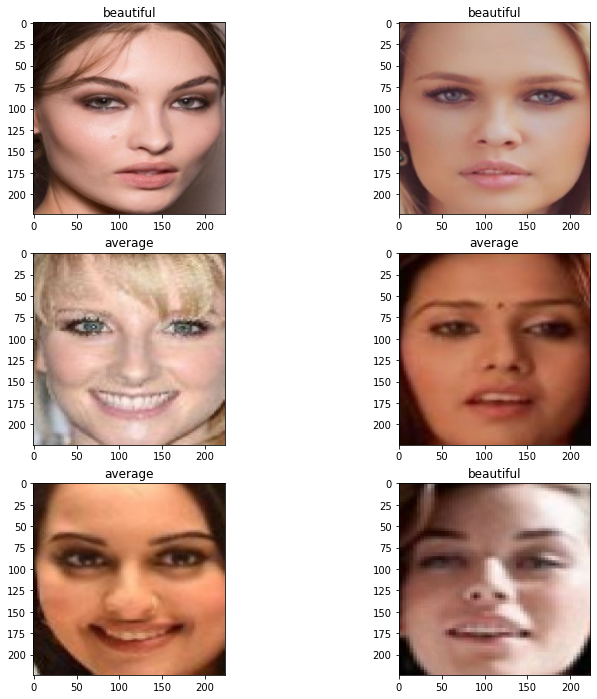

In [ ]:
subset = df.sample(6).reset_index()
plt.figure(figsize=(12, 12))
for i in range(len(subset)):
    img = mpimg.imread(subset.loc[i, "filepaths"])
    label = subset.loc[i, "labels"]
    plt.subplot(3,2, i+1)
    plt.imshow(img)
    plt.title(label)
plt.show()

Data

In [ ]:
class Data(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.files = df["filepaths"].values
        self.y = df["y"].values
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return torchvision.io.read_image(self.files[i]) / 255.0, self.y[i]
    
train_ds = Data(df[df["data set"]=="train"])
valid_ds = Data(df[df["data set"]=="valid"])
test_ds = Data(df[df["data set"]=="test"])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, freeze=True):
        super().__init__()
        self.base = torchvision.models.resnet34(pretrained=False)
        self.base.fc = nn.Identity()
        self.bn = nn.BatchNorm1d(512)
        self.linear = nn.Linear(512, num_classes)
        
        if freeze:
            self.base = self.base.eval()
            for p in self.base.parameters():
                p.requires_grad = False
        
    def forward(self, x):
        return self.linear(self.bn(self.base(x)))

class LightningModel(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, loss_fn: Callable) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        self.accuracy = lambda x, y: (x.argmax(-1) == y).float().mean()
        
    def common_step(
        self, 
        batch: Tuple[torch.FloatTensor, torch.LongTensor],
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc
    
    def training_step(self, batch: Tuple[torch.FloatTensor, torch.LongTensor], *args) -> torch.FloatTensor:
        loss, acc = self.common_step(batch)
        self.log("training_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("training_accuracy", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch: Tuple[torch.FloatTensor, torch.LongTensor], *args) -> None:
        loss, acc = self.common_step(batch)
        self.log("validation_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("validation_accuracy", acc, on_step=True, on_epoch=True, prog_bar=True)
                        
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), self.lr)

In [ ]:
model = Model(len(le.classes_))
lightning_model = LightningModel(model, lr=LR, loss_fn=nn.CrossEntropyLoss())


In [ ]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=torch.cuda.device_count(),
)

trainer.fit(lightning_model, train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 21.3 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.0 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.eval().to(device)

y_preds = []
ys = []
for x, y in tqdm(test_dl):
    y_preds.append(model(x.to(device)).argmax(dim=-1))
    ys.append(y.to(device))
    
(torch.cat(y_preds) == torch.cat(ys)).float().mean()

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.5433)

In [ ]:
class Data(Dataset):
  def __init__(self, df: pd.DataFrame) ->None:
    self.files = df['filepaths'].values
    self.y = df["y"].values

  def __len__(self):
    return len(self.y)


  def __getitem__(self, i):
    return torchvision.io.read_image(self.files[i] / 255.0, self.y[i])


train_ds = Data(df[df["data set"] == "train"])
test_ds = Data(df[df["data set"] == "test"])
valid_ds = Data(df[df["data set"] == "valid"]) 


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, 
                      num_workers=2, pin_memory=True)

test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = True,
                      num_workers = 2, pin_memory = True)

valid_dl = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = True,
                      num_workers = 2, pin_memory = True)





Model

In [ ]:
class Model(nn.Module):
  def __init__(self, num_classes, freeze = True):
    super().__init__()
    self.base = torchvision.models.resnet34(pretrained = False)
    self.base.fc = nn.Identity()
    self.bn = nn.BatchNorm1d(512)
    self.linear = nn.Linear(512, num_classes)

    if freeze:
      self.base = self.base.eval()
      for p in self.base.parameters():
        p.requires_grad = False


  def forward(self, x):
    return self.linear(self.bn(self.base(x))) 



class LightningModel(pl.LightningModule):
  def __init__(self, model: nn.Module, lr:float, loss_fn:Callable) ->None:
    super().__init__()
    self.model = model
    self.lr = lr 
    self.loss_fn = loss_fn
    self.accuracy = lambda x, y: (x.argmax(-1) == y).float().mean()   




  def common_step(
      self,
      batch:Tuple[torch.FloatTensor, torch.LongTensor],)-> Tuple[torch.FloatTensor, torch.FloatTensor]: 
  #-> Tuple[torch.FloatTensor, torchFloatTensor]:
      x, y = batch
      logits = self.model(x)
      loss = self.loss_fn(logits, y)
      acc = self.accuracy(logits, y)
      return loss, acc
  

  def training_step(self, batch: Tuple[torch.FloatTensor, torch.LongTensor], *argd)->torch.FloatTensor:
    loss, acc = self.common_step(batch)
    self.log('training_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
    self.log('training_accuracy', acc, on_step = True, on_epoch = True, prog_bar = True)
    return loss


  def validation_step(self, batch: Tuple[torch.FloatTensor, torch.LongTensor], *arg)->None:
    long, acc = self.common_step(batch)
    self.log('validation_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
    self.log('validation_accuracy', acc, on_step = True, on_epoch = True, prog_bar = True)

  def configure_optimizers(self) -> torch.optim.Optimizer:
    return torch.optim.Adam(self.model.parameters(), self.lr)           

In [ ]:
model = Model(len(le.classes_))
lightning_model =  LightningModel(model, lr=LR, loss_fn=nn.CrossEntropyLoss())

Training

In [ ]:
trainer = pl.Trainer(max_epochs = EPOCHS, 
                     gpus = torch.cuda.device_count(),)

trainer.fit(lightning_model, train_dl, valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 21.3 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.0 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


TypeError: ignored